# ManiSkill2 Tutorial: Customize Environments

ManiSkill2 comes with improved tooling to customize environments for your own research and applications. In this tutorial, we will showcase how to customize ManiSkill2 environments and will cover the following:
- customizing cameras (e.g., resolutions, poses)
- adding dynamic objects and static scenes
- changing the robot
- domain randomization
- adjusting lighting

In [1]:
import sys

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

# Register ManiSkill2 environments in gym
import mani_skill2.envs

def plot_img(img, title=None):
    plt.figure(figsize=(10,6))
    if title is not None:
        plt.title(title)
    plt.imshow(img)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The camera configurations are defined during the initialization of an environment and will not change. ManiSkill2 environments all have default camera configurations. You can also update them by passing `camera_cfgs` (cameras for visual observations) and `render_camera_cfgs` (cameras for rendering/visualization only) to the initialization function.

## Change the Robot

In this section, we will showcase how to customize the existing robot and add a new robot. In ManiSkill2, the agent is a collection of the robot, mounted cameras, and controllers.

### Add a new robot

Adding a new robot in ManiSkill2 includes several aspects:
- Download or create URDF and assets (usually from the ROS package).  
- Implement an agent class inherited from `BaseAgent`
- Implement agent configurations (controllers, cameras, ...)
- Support the new agent class in the environment

We refer readers to our implementation of Xmate3 as an example. The environments in `mani_skill2.envs.pick_and_place` all support Xmate3.

```python
from mani_skill2.agents.robots.xmate3 import Xmate3Robotiq
from mani_skill2.agents.configs.xmate3.defaults import Xmate3RobotiqDefaultConfig
```

### env = gym.make("PickCube-v0", robot="xarm7")
plot_img(env.unwrapped.render_cameras())
env.close()
del env

In [8]:
env = gym.make("PickCube-v0", robot="xarm7")
# plot_img(env.unwrapped.render_cameras())
print(env.agent.action_space)
env.close()
# del env

Box([-6.2831855 -2.059     -6.2831855 -0.19198   -6.2831855 -1.69297
 -6.2831855 -1.       ], [6.2831855 2.0944    6.2831855 3.927     6.2831855 3.1415927 6.2831855
 1.       ], (8,), float32)


[2024-03-13 08:11:16.706] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.


[2024-03-13 08:10:54.975] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.


Box(-1.0, 1.0, (8,), float32)


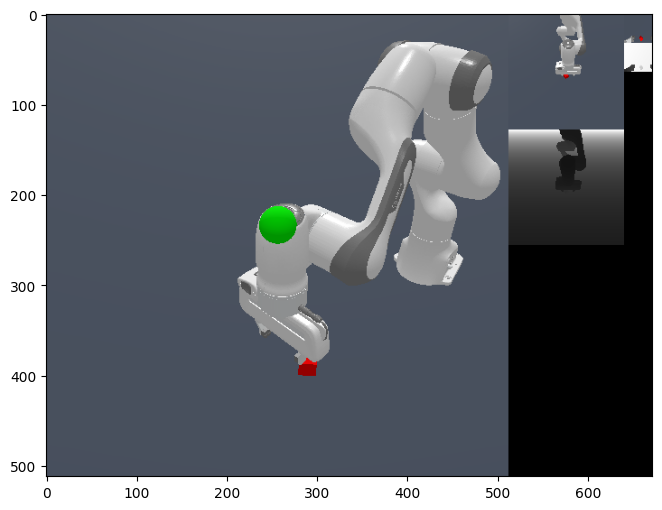

In [7]:
env = gym.make("PickCube-v0", robot="panda")
plot_img(env.unwrapped.render_cameras())
print(env.agent.action_space)
env.close()
del env

[2024-03-13 08:14:59.021] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.


Box([-3.0527 -2.0933 -3.0527 -2.0933 -3.0527 -2.0933 -6.283  -1.    ], [3.0527 2.0933 3.0527 2.0933 3.0527 2.0933 2.993  1.    ], (8,), float32)


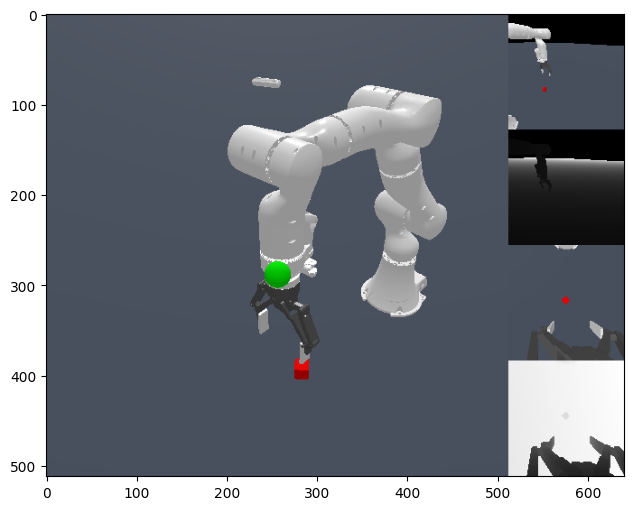

In [9]:
env = gym.make("PickCube-v0", robot="xmate3_robotiq")
plot_img(env.unwrapped.render_cameras())
print(env.agent.action_space)
env.close()
del env

[2024-03-12 11:19:48.507] [svulkan2] [error] GLFW error: X11: The DISPLAY environment variable is missing
[2024-03-12 11:19:48.507] [svulkan2] [warning] Continue without GLFW.


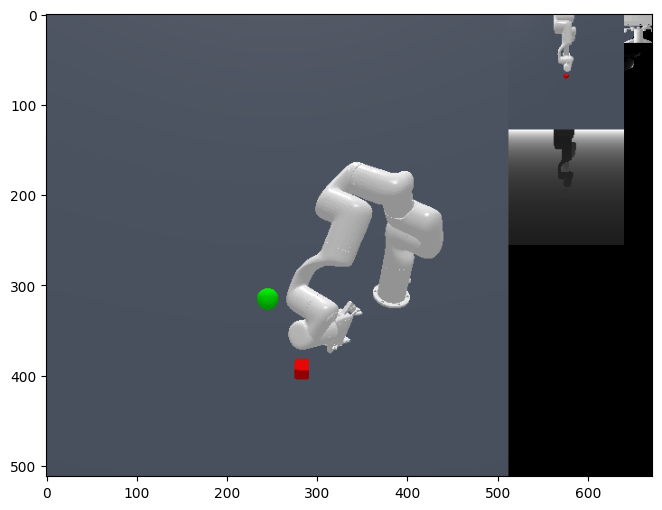

In [10]:
env = gym.make("PickCube-v0", robot="xarm7")
plot_img(env.unwrapped.render_cameras())
env.close()
del env

## Domain randomization

In this section, we will showcase how to add domain randomization (e.g., visual appearance, physical parameters).

First, we show how we randomize physical parameters and visual apperance, which can be applied without reconfiguring the simulation scene.

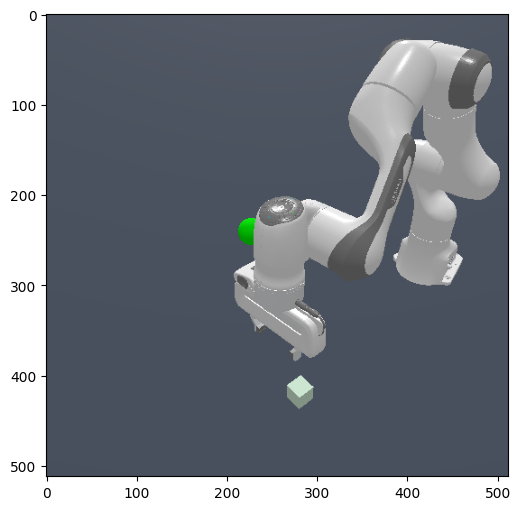

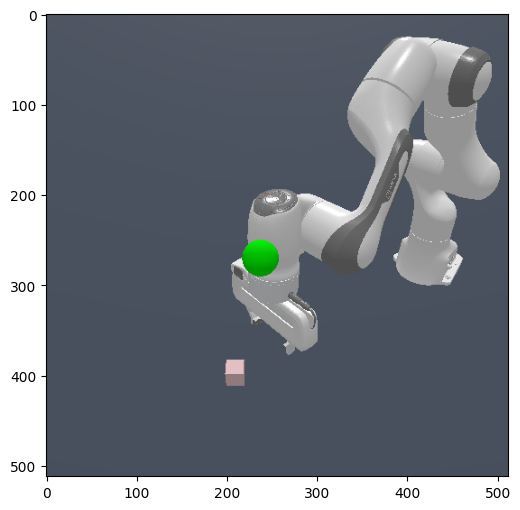

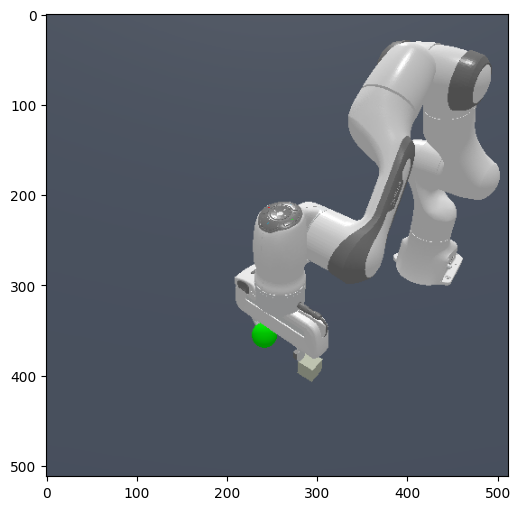

In [15]:
import sapien.core as sapien

from mani_skill2.envs.pick_and_place.pick_cube import PickCubeEnv
from mani_skill2.utils.registration import register_env
from mani_skill2.utils.sapien_utils import set_render_material


@register_env("DR-PickCube-v0", max_episode_steps=100, override=True)
class DomainRandomizationPickCubeEnv(PickCubeEnv):
    def _initialize_actors(self):
        super()._initialize_actors()

        # Example: randomize friction
        friction = self._episode_rng.uniform(0.5, 1.0)
        phys_mtl = self._scene.create_physical_material(
            static_friction=friction, dynamic_friction=friction, restitution=0.1
        )
        for cs in self.obj.get_collision_shapes():
            cs.set_physical_material(phys_mtl)

        # Example: randomize damping
        linear_damping = self._episode_rng.uniform(0, 1.0)
        angular_damping = self._episode_rng.uniform(0, 1.0)
        self.obj.set_damping(linear_damping, angular_damping)

        # Example: randomize color
        color = self._episode_rng.uniform(0.5, 1.0, size=3)
        for vb in self.obj.get_visual_bodies():
            for rs in vb.get_render_shapes():
                set_render_material(rs.material, color=np.hstack([color, 1.0]))


env = gym.make("DR-PickCube-v0")
for _ in range(3):
    env.reset()
    plot_img(env.unwrapped.render_rgb_array())
env.close()
del env


Next, we show how to randomize object properties, which require reconfiguring the simulation scene.

2023-08-19 02:28:21,663 - mani_skill2 - WARNING - Override registered env DR-PickCube-v1


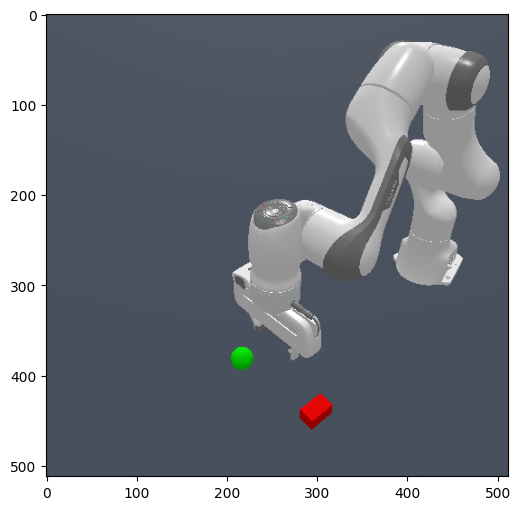

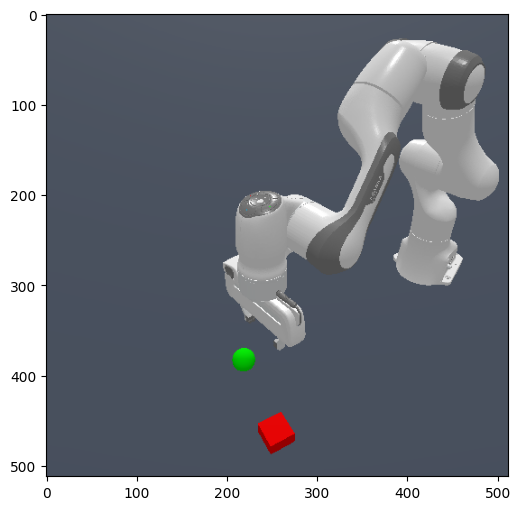

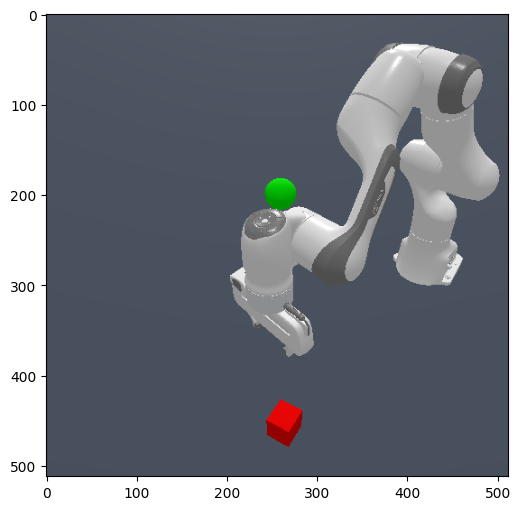

In [17]:
import sapien.core as sapien

from mani_skill2.envs.pick_and_place.pick_cube import PickCubeEnv
from mani_skill2.utils.registration import register_env


@register_env("DR-PickCube-v1", max_episode_steps=100, override=True)
class DomainRandomizationPickCubeEnvV1(PickCubeEnv):
    # Reconfigure the environment when reset by default
    def reset(self, seed=None, options=None):
        return super().reset(seed, options=dict(reconfigure=True))

    def _load_actors(self):
        self.cube_half_size = self._episode_rng.uniform(0.01, 0.03, size=3)
        super()._load_actors()


env = gym.make("DR-PickCube-v1")
for _ in range(3):
    env.reset()
    plot_img(env.unwrapped.render_rgb_array())
env.close()
del env

## Adjust lighting

You can enable shadows to improve photorealism as shown below

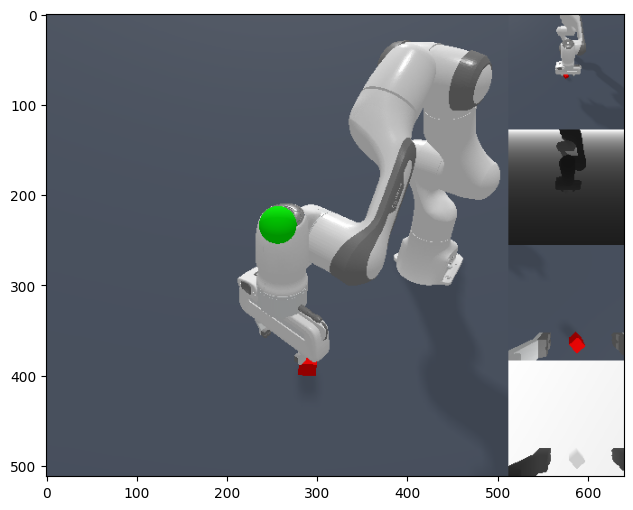

In [18]:
env = gym.make("PickCube-v0", enable_shadow=True)
plot_img(env.unwrapped.render_cameras())
env.close()
del env

You can override `_setup_lighting` to modify lighting directly as well

2023-08-19 02:28:46,166 - mani_skill2 - WARNING - Override registered env PickCube-Light-v0


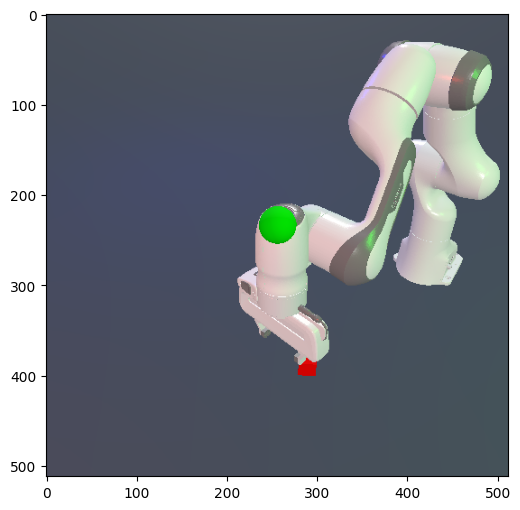

In [20]:
from mani_skill2.envs.pick_and_place.pick_cube import PickCubeEnv
from mani_skill2.utils.registration import register_env


@register_env("PickCube-Light-v0", max_episode_steps=100, override=True)
class PickCubeLightEnv(PickCubeEnv):
    def _setup_lighting(self):
        shadow = self.enable_shadow
        self._scene.set_ambient_light([0.3, 0.3, 0.3])
        # Only the first of directional lights can have shadow
        self._scene.add_directional_light(
            [1, 1, -1], [1, 1, 1], shadow=shadow, scale=5, shadow_map_size=2048
        )
        self._scene.add_directional_light([-1, -1, -1], [1, 1, 1])
        self._scene.add_point_light([1, 0, 1], [1, 0, 0], shadow=shadow)
        self._scene.add_point_light([-0.5, 1, 1], [0, 1, 0], shadow=shadow)
        self._scene.add_point_light([-0.5, -1, 1], [0, 0, 1], shadow=shadow)


env = gym.make("PickCube-Light-v0")
plot_img(env.unwrapped.render_rgb_array())
env.close()
del env